# 모델링

## 1. 설정
- 필요한 라이브러리 임포트:
  - `pandas`, `sklearn`, `imblearn`, `matplotlib`

## 2. 데이터 로드
- `pokemon_preprocessed.csv` 파일에서 데이터프레임 생성.
- 데이터 미리보기: `df.head()`

## 3. 학습 데이터 준비
- `preparation` 모듈로 학습 데이터 준비.
- SMOTE를 사용하여 데이터 불균형 문제 해결.
- 학습 및 테스트 데이터로 분할.

## 4. 모델 학습
- 랜덤 포레스트 분류기 모델 생성 및 학습.

## 5. 모델 평가
- 테스트 데이터에 대한 예측 수행.
- 분류 보고서 및 혼동 행렬 출력.
- KFold 교차 검증을 통해 F1 점수 계산.

## 6. 향후 개선점
- 잘못 분류된 포켓몬 추출.
- 잘못 분류된 포켓몬의 능력치 확인.

## 7. 모델 저장
- 학습된 모델을 `joblib`를 사용하여 파일로 저장.

## Set Up

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('pokemon_preprocessed.csv')

In [3]:
df.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,have2types,...,Grass,Ground,Ice,None,Normal,Poison,Psychic,Rock,Steel,Water
0,318,45,49,49,65,65,45,1,False,True,...,False,False,False,False,False,True,False,False,False,False
1,405,60,62,63,80,80,60,1,False,True,...,False,False,False,False,False,True,False,False,False,False
2,525,80,82,83,100,100,80,1,False,True,...,False,False,False,False,False,True,False,False,False,False
3,625,80,100,123,122,120,80,1,False,True,...,False,False,False,False,False,True,False,False,False,False
4,309,39,52,43,60,50,65,1,False,False,...,False,False,False,True,False,False,False,False,False,False


## 학습 데이터 준비

In [4]:
import preparation as prep
from imblearn.over_sampling import SMOTE

X, y, _, _ = prep.get_dataset(df, 'Legendary')

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

## 모델 학습

In [5]:
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 모델 평가

In [6]:
y_pred = model.predict(X_test)

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97       221
        True       0.94      1.00      0.97       220

    accuracy                           0.97       441
   macro avg       0.97      0.97      0.97       441
weighted avg       0.97      0.97      0.97       441



In [8]:
print(confusion_matrix(y_test, y_pred))

[[208  13]
 [  0 220]]


In [9]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='f1')

print(round(scores.mean(), 2))

0.98


## 향후 개선점

In [10]:
incorrect_predictions = X_test[y_test != y_pred]
incorrect_predictions_index = incorrect_predictions.index

In [11]:
pokemon = pd.read_csv('./data/pokemon.csv')

pokemon.iloc[incorrect_predictions_index]

# 일반 포켓몬이지만 전설 포켓몬으로 잘못 분류한 13개의 포켓몬은 모두 전설 포켓몬급 능력치를 갖고 있었다.

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
165,151,Mew,Psychic,NaN,600,100,100,100,100,100,100,1,False
714,647,KeldeoResolute Forme,Water,Fighting,580,91,72,90,129,90,108,5,False
71,65,AlakazamMega Alakazam,Psychic,NaN,590,55,50,65,175,95,150,1,False
408,373,Salamence,Dragon,Flying,600,95,135,80,110,80,100,3,False
267,248,Tyranitar,Rock,Dark,600,100,134,110,95,100,61,2,False
546,488,Cresselia,Psychic,NaN,600,120,70,120,75,130,85,4,False
397,362,GlalieMega Glalie,Ice,NaN,580,80,120,80,120,80,100,3,False
248,229,HoundoomMega Houndoom,Dark,Fire,600,75,90,90,140,90,115,2,False
548,490,Manaphy,Water,NaN,600,100,100,100,100,100,100,4,False
696,635,Hydreigon,Dark,Dragon,600,92,105,90,125,90,98,5,False


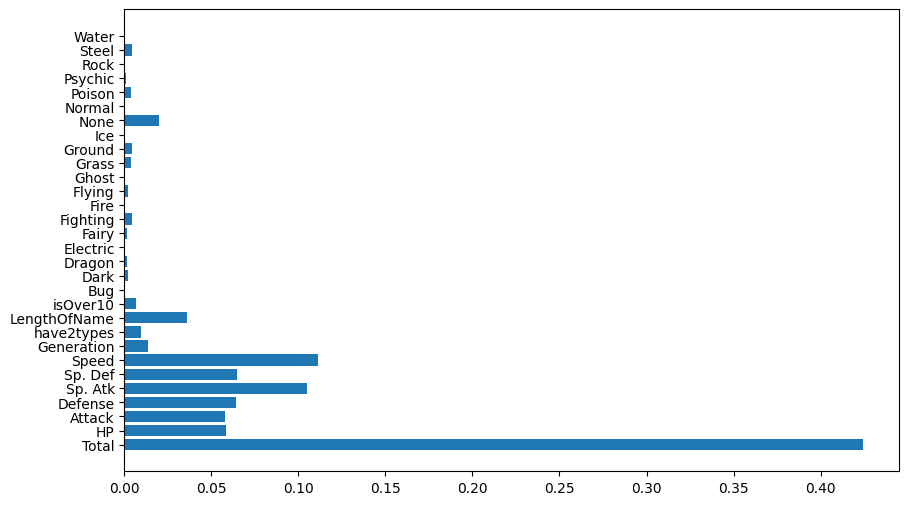

In [12]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.show()

# 앞서 EDA에서 예상했던대로 Total 변수가 분류 모델에 지대한 영향을 미쳤다.

## 모델 저장

In [13]:
from joblib import dump
dump(model, './model/model1(f1_0.98).pkl')

['./model/model1(f1_0.98).pkl']